In [1]:
import string
from collections import Counter

import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [2]:
df = pd.read_csv('unsc.csv')

In [3]:
df.full_date.sort_values()

0        1995-01-06
29       1995-01-12
30       1995-01-12
31       1995-01-12
32       1995-01-12
            ...    
78639    2020-12-22
78681    2020-12-22
78643    2020-12-22
78673    2020-12-29
78672    2020-12-29
Name: full_date, Length: 82200, dtype: object

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82200 entries, 0 to 82199
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   country           82200 non-null  object
 1   full_date         82200 non-null  object
 2   speech            82200 non-null  object
 3   speech_tokenized  82200 non-null  object
 4   topic             82200 non-null  object
dtypes: object(5)
memory usage: 3.1+ MB


In [5]:
df.head(2)

,country,full_date,speech,speech_tokenized,topic
0,Argentina,1995-01-06,As this is the first meeting of the Security C...,"['As', 'this', 'is', 'the', 'first', 'meeting'...",Bosnia and Herzegovina
1,Argentina,1995-01-12,I should like at the outset of the meeting to ...,"['I', 'should', 'like', 'at', 'the', 'outset',...",Federal Republic of Yugoslavia (Serbia and Mon...


# Pre processing text

In [6]:
stop_words = set(stopwords.words('english'))

additional_stop_words = ['also', 'would', 'must', 'like', 'need', 'continue', 'take', 'country', 
                        'you', 'make', 'mr', 'including', 'member', 'committee', 'situation',
                        'united', 'nation', 'item', 'invite', 'speaker', 'representative', 'accordance', 
                        'thank', 'vote', 'meeting', 'president', 'floor', 'participate', 
                        'consideration', 'region', 'state', 'international']  

lemmatizer = WordNetLemmatizer()

In [7]:
def preprocess_text(text):

    # Remoção de stopwords e pontuações
    preprocessed_text = text.lower()
    preprocessed_text = ''.join([char for char in preprocessed_text if char not in string.punctuation])
    preprocessed_text = ' '.join([word for word in preprocessed_text.split() if word not in stop_words and word.isalpha()])
    preprocessed_text = ' '.join([word for word in preprocessed_text.split() if word not in additional_stop_words and word.isalpha()])

    # Lematização
    preprocessed_text = ' '.join([lemmatizer.lemmatize(word) for word in preprocessed_text.split()])

    return preprocessed_text


df['processed_speech'] = df['speech'].apply(preprocess_text)

In [8]:
df['processed_speech'] = df['processed_speech'].str.replace('I now give the floor to', '')
df['processed_speech'] = df['processed_speech'].str.replace('I thank the representative of', '')

In [9]:
def gather_most_frequent_words(data, column, top_n):

    text = ' '.join(data[column])
    words = text.split()
    word_counts = Counter(words)
    most_frequent_words = word_counts.most_common(top_n)

    return most_frequent_words

In [10]:
most_frequent_words = gather_most_frequent_words(df, 'processed_speech', top_n=100)
most_frequent_words

[('council', 305518),
 ('security', 269603),
 ('nation', 187834),
 ('peace', 167557),
 ('conflict', 125591),
 ('resolution', 124821),
 ('support', 120205),
 ('effort', 113444),
 ('government', 100122),
 ('state', 98449),
 ('people', 93311),
 ('community', 86445),
 ('political', 85200),
 ('process', 82413),
 ('humanitarian', 78828),
 ('work', 77001),
 ('country', 72371),
 ('right', 72340),
 ('report', 71237),
 ('development', 70045),
 ('important', 66955),
 ('mission', 65259),
 ('woman', 65205),
 ('issue', 63775),
 ('national', 62027),
 ('law', 60725),
 ('party', 60134),
 ('civilian', 59646),
 ('force', 59036),
 ('secretarygeneral', 58566),
 ('year', 58255),
 ('organization', 57407),
 ('african', 56537),
 ('group', 55440),
 ('cooperation', 55359),
 ('today', 54818),
 ('human', 53595),
 ('republic', 53321),
 ('action', 53201),
 ('member', 53155),
 ('welcome', 52305),
 ('violence', 52132),
 ('child', 51773),
 ('one', 50834),
 ('well', 50246),
 ('regard', 50216),
 ('made', 49489),
 ('new',

# Training model

In [34]:
import warnings
# Suprimindo o aviso de depreciação
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [37]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pandas as pd

def train_dynamic_topic_model(data, num_topics, max_iter):
    # Inicialização do vetorizador para transformar os textos em uma matriz de contagem de palavras
    vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
    X = vectorizer.fit_transform(data['processed_speech'])
    
    # Treinamento do modelo de LDA
    lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42, max_iter=max_iter)
    lda_model.fit(X)
    
    # Extração das palavras-chave para cada tópico identificado
    feature_names = vectorizer.get_feature_names_out()
    topic_keywords = {}
    for topic_idx, topic in enumerate(lda_model.components_):
        # Obtém as palavras mais importantes para cada tópico
        topic_keywords[topic_idx] = [feature_names[i] for i in topic.argsort()[-10:]]
    
    # Atribuição de tópicos ao DataFrame
    topics_assigned = []
    lda_topics = []  # New list to store topic IDs
    for text in data['processed_speech']:
        topics = lda_model.transform(vectorizer.transform([text]))[0]
        dominant_topic = topics.argmax()
        topics_assigned.append(topic_keywords[dominant_topic])
        lda_topics.append(f"topic_{dominant_topic}")  # Create topic ID
        
    # Adiciona os tópicos atribuídos como novas colunas no DataFrame
    data['assigned_topics'] = topics_assigned
    data['lda_topic'] = lda_topics  # Add new column with topic IDs
    
    return lda_model, topic_keywords


dynamic_lda, dynamic_topic_keywords = train_dynamic_topic_model(df[:100], num_topics=5, max_iter=100)
df.head(2)

C:\Users\anton\AppData\Local\Temp\ipykernel_29324\1768707415.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['assigned_topics'] = topics_assigned
C:\Users\anton\AppData\Local\Temp\ipykernel_29324\1768707415.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['lda_topic'] = lda_topics  # Add new column with topic IDs


,country,full_date,speech,speech_tokenized,topic,processed_speech,assigned_topics,lda_topic
0,Argentina,1995-01-06,As this is the first meeting of the Security C...,"['As', 'this', 'is', 'the', 'first', 'meeting'...",Bosnia and Herzegovina,first security council held year welcome new m...,"[state, republic, agenda, statement, rule, dra...",topic_0
1,Argentina,1995-01-12,I should like at the outset of the meeting to ...,"['I', 'should', 'like', 'at', 'the', 'outset',...",Federal Republic of Yugoslavia (Serbia and Mon...,outset apologize everyone delay starting ackno...,"[state, republic, agenda, statement, rule, dra...",topic_0


In [13]:
df.assigned_topics.value_counts()

assigned_topics
[state, republic, agenda, statement, rule, draft, member, resolution, security, council]             25869
[state, country, development, african, effort, council, support, peace, nation, security]            22030
[process, israeli, people, east, israel, kosovo, council, security, peace, palestinian]              12417
[civilian, syria, party, iraq, council, political, afghanistan, government, people, humanitarian]    11990
[violence, civilian, right, nation, armed, security, child, council, woman, conflict]                 9894
Name: count, dtype: int64

In [14]:
df.to_csv('UNSC_Final.csv', index=False)

In [15]:
df.head(2)

,country,full_date,speech,speech_tokenized,topic,processed_speech,assigned_topics,lda_topic
0,Argentina,1995-01-06,As this is the first meeting of the Security C...,"['As', 'this', 'is', 'the', 'first', 'meeting'...",Bosnia and Herzegovina,first security council held year welcome new m...,"[state, republic, agenda, statement, rule, dra...",topic_0
1,Argentina,1995-01-12,I should like at the outset of the meeting to ...,"['I', 'should', 'like', 'at', 'the', 'outset',...",Federal Republic of Yugoslavia (Serbia and Mon...,outset apologize everyone delay starting ackno...,"[state, republic, agenda, statement, rule, dra...",topic_0


# Results

C:\Users\anton\AppData\Local\Temp\ipykernel_29324\1188122483.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lda_topic_desejado[word + '_freq'] = df_lda_topic_desejado['processed_speech'].str.count(word)
C:\Users\anton\AppData\Local\Temp\ipykernel_29324\1188122483.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lda_topic_desejado[word + '_freq'] = df_lda_topic_desejado['processed_speech'].str.count(word)
C:\Users\anton\AppData\Local\Temp\ipykernel_29324\1188122483.py:12: SettingWithCopyWarni

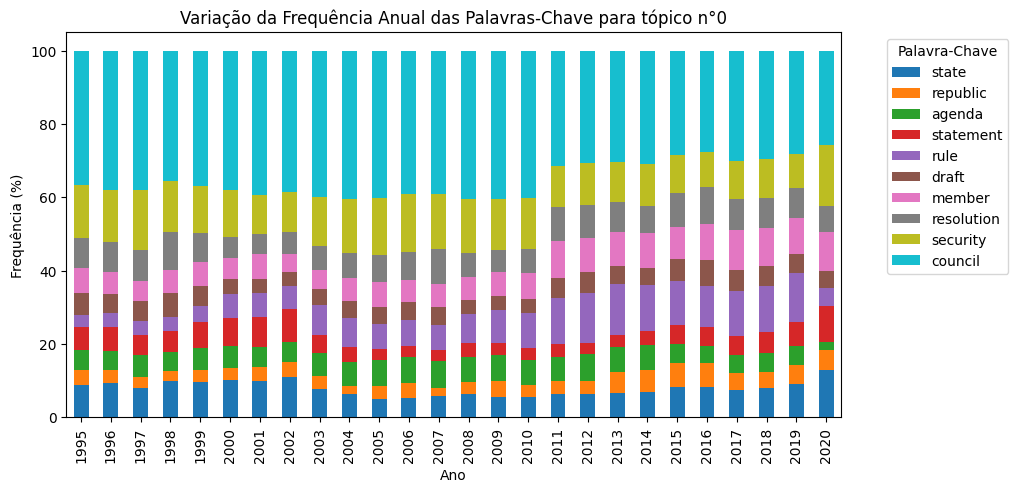

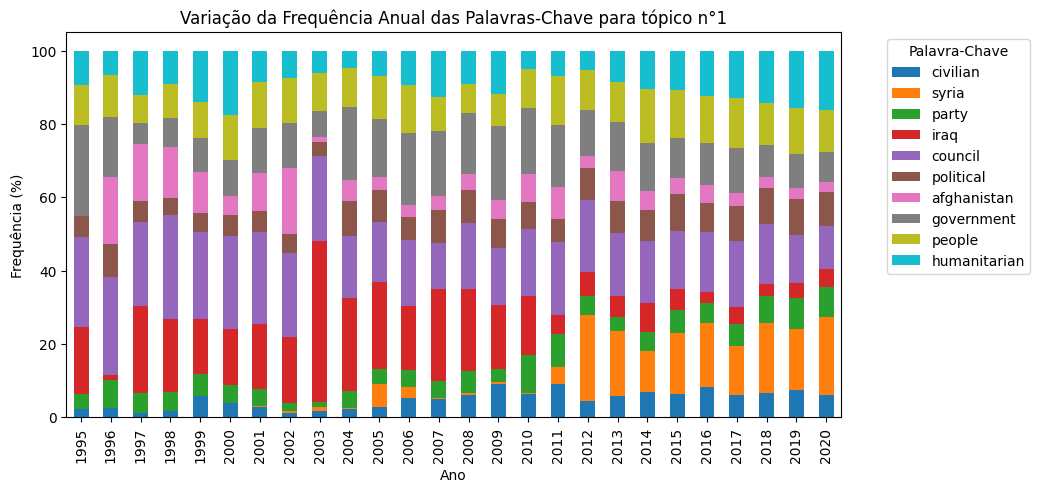

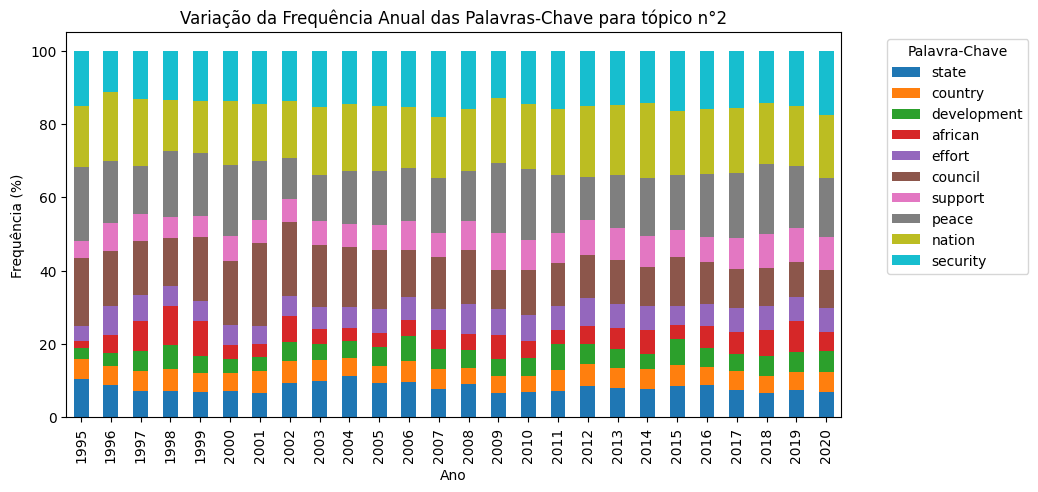

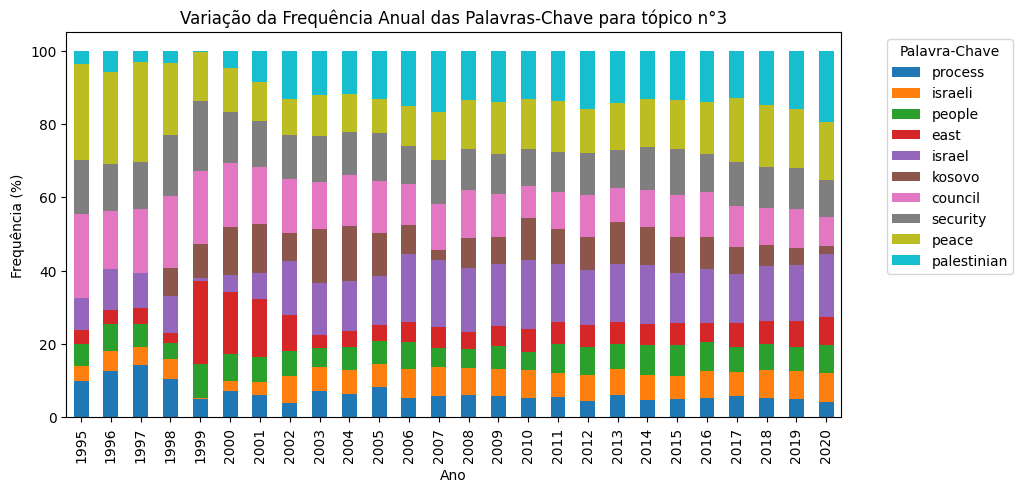

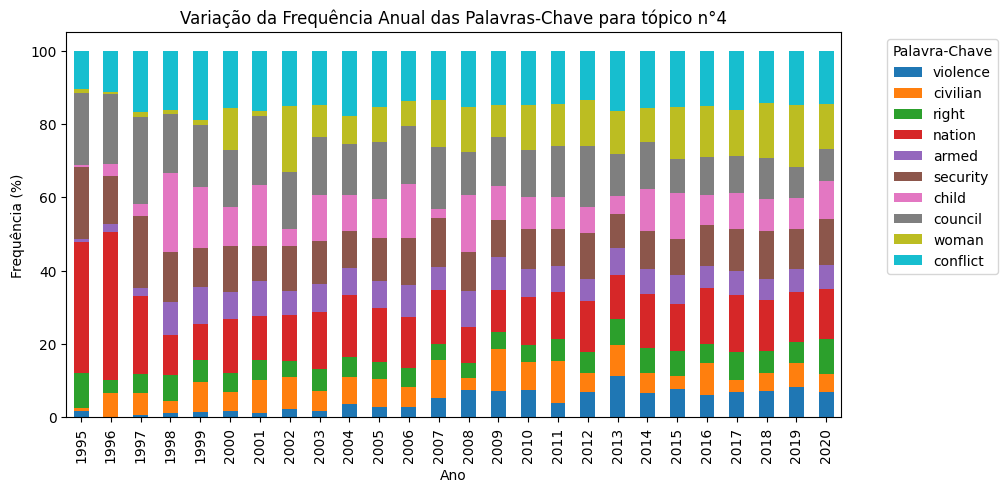

In [16]:
import matplotlib.pyplot as plt
import pandas as pd

def get_keywords_freq(lda_topic):
    lda_topic_desejado = lda_topic
    df_lda_topic_desejado = df[df['lda_topic'] == lda_topic_desejado]
    iterator = int(lda_topic.replace('topic_', ''))

    keywords = dynamic_topic_keywords[iterator]
    
    for word in keywords:
        df_lda_topic_desejado[word + '_freq'] = df_lda_topic_desejado['processed_speech'].str.count(word)

    df_lda_topic_desejado['full_date'] = pd.to_datetime(df_lda_topic_desejado['full_date'])
    df_lda_topic_desejado['year'] = df_lda_topic_desejado['full_date'].dt.year
    yearly_frequency = df_lda_topic_desejado.groupby(by='year')[[word + '_freq' for word in keywords]].sum()

    # Normalizando os dados para 100% empilhado
    yearly_frequency = yearly_frequency.div(yearly_frequency.sum(axis=1), axis=0) * 100

    yearly_frequency.columns = [column.replace('_freq', '') for column in yearly_frequency.columns]
    
    fig, ax = plt.subplots(figsize=(10, 5))

    # Criando o gráfico de barras 100% empilhado
    yearly_frequency.plot(kind='bar', stacked=True, ax=ax)

    plt.title(f'Variação da Frequência Anual das Palavras-Chave para tópico n°{iterator}')
    plt.xlabel('Ano')
    plt.ylabel('Frequência (%)')
    plt.legend(title='Palavra-Chave',  bbox_to_anchor=(1.05, 1), loc='best')
    plt.grid(False)
    plt.savefig(f'charts/{lda_topic}', bbox_inches='tight')

for topic in df['lda_topic'].sort_values().unique():
    get_keywords_freq(lda_topic=topic)


# Coherence Score

In [28]:
import tmtoolkit
from tmtoolkit.topicmod.evaluate import metric_coherence_gensim
import numpy as np

# Transforme os dados de texto em uma matriz de contagem de palavras
X = vectorizer.fit_transform(df['processed_speech'])

# Obtenha os nomes das palavras do vetorizador
feature_names = vectorizer.get_feature_names_out()
input()
# Calcule a distribuição de palavras-tópico do modelo LDA
topic_word_distrib = dynamic_lda.components_

# Calcule a coherência usando a função metric_coherence_gensim do tmtoolkit
coherence_score = metric_coherence_gensim(
    measure='c_v', # Escolha a medida de coherência desejada (c_v, u_mass, etc.)
    top_n=10, # Número de palavras-tópico a serem consideradas
    topic_word_distrib=topic_word_distrib,
    dtm=X, # A matriz de contagem de palavras
    vocab=np.array(feature_names), # Os nomes das palavras
    texts=df['processed_speech'].tolist() # Os textos originais
)

print("Coherence Score:", coherence_score)


Coherence Score: [nan, nan, nan, nan, nan]


c:\Users\anton\AppData\Local\Programs\Python\Python310\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in scalar divide
  m_lr_i = np.log(numerator / denominator)
c:\Users\anton\AppData\Local\Programs\Python\Python310\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in scalar divide
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


In [29]:
coherence_score

[nan, nan, nan, nan, nan]

# Perplexity